Step 1: Import library

In [14]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


# ==========================
# Data & basic tools
# ==========================
import pandas as pd
import numpy as np

# ==========================
# Visualization
# ==========================
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# Statistical analysis
# ==========================
from scipy.stats import (
    ttest_ind, 
    levene, 
    chi2_contingency, 
    skew, 
    kurtosis, 
    pearsonr, 
    f_oneway
)
import statsmodels.api as sm

# ==========================
#  Structural Equation Modeling
# ==========================
from semopy import Model, calc_stats

# ==========================
# Time series modeling
# ==========================
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ==========================
# Machine Learning (Random Forest)
# ==========================
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==========================
# Deep Learning (LSTM)
# ==========================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


Step 2: Preprocess data

Step 2.1: Read data and drop some unused columns

In [15]:
df = pd.read_csv("../../Dataset/household.csv")

In [16]:
df = df.drop([
    'main',
    'description',
    'temp_min',
    'temp_max',
    'temp_t+1',
    'feels_like_t+1',
    'deg',
    'current',
    'voltage',
    'reactive_power',
    'apparent_power',
    'power_factor'
], axis=1)

Step 2.2: Load data and resample to hour

In [17]:

# change date column into datetime 
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date')

# merge data by hour (mean)
df_hour = (
    df.set_index('date')
      .resample('H')
      .mean(numeric_only=True)  
      .reset_index()
)

print("The initial columns:", len(df), "→ After merging followed by hour:", len(df_hour))
df_hour

The initial columns: 605260 → After merging followed by hour: 10234


,date,active_power,temp,feels_like,pressure,humidity,speed
0,2022-11-05 14:00:00,248.780000,24.246364,23.728182,1011.909091,38.436364,0.081818
1,2022-11-05 15:00:00,202.663333,24.302000,23.765333,1010.666667,37.366667,2.912167
2,2022-11-05 16:00:00,198.863333,24.174000,23.605833,1011.416667,36.666667,2.322667
3,2022-11-05 17:00:00,390.181667,23.485667,22.830667,1010.600000,36.083333,2.455000
4,2022-11-05 18:00:00,443.036667,21.693667,20.933333,1008.816667,38.783333,2.269500
...,...,...,...,...,...,...,...
10229,2024-01-05 19:00:00,329.995556,13.546889,12.099556,1013.733333,43.733333,2.396889
10230,2024-01-05 20:00:00,393.211864,11.364576,9.752203,1012.559322,45.779661,0.279322
10231,2024-01-05 21:00:00,233.649153,10.550508,8.994915,1014.288136,51.067797,0.151525
10232,2024-01-05 22:00:00,374.113333,9.260333,8.541500,1012.100000,50.766667,1.621000


Step 2.3: Prepare some data columns

In [18]:


df_hour['weekday'] = df_hour['date'].dt.weekday
df_hour['is_weekend'] = df_hour['weekday'].isin([5,6]).astype(int)

# Lag features
df_hour['ap_lag_1h'] = df_hour['active_power'].shift(1)
df_hour['ap_lag_24h'] = df_hour['active_power'].shift(24)
df_hour['ap_roll_24h'] = df_hour['active_power'].rolling(24, min_periods=1).mean()
df_hour.dropna(inplace=True)

Step 2.4: View data

In [19]:
df_hour

,date,active_power,temp,feels_like,pressure,humidity,speed,weekday,is_weekend,ap_lag_1h,ap_lag_24h,ap_roll_24h
24,2022-11-06 14:00:00,163.376667,28.653167,27.250167,1013.916667,21.083333,3.781167,6,1,224.355000,248.780000,273.720891
25,2022-11-06 15:00:00,297.003333,28.226667,26.947833,1013.016667,21.516667,4.559333,6,1,163.376667,202.663333,277.651724
26,2022-11-06 16:00:00,396.440000,27.816167,26.716833,1013.250000,22.916667,4.938667,6,1,297.003333,198.863333,285.884085
27,2022-11-06 17:00:00,311.295000,25.777500,25.265667,1013.166667,24.566667,4.757667,6,1,396.440000,390.181667,282.597141
28,2022-11-06 18:00:00,443.610000,23.328667,22.383333,1011.133333,25.483333,4.779167,6,1,311.295000,443.036667,282.621030
...,...,...,...,...,...,...,...,...,...,...,...,...
10229,2024-01-05 19:00:00,329.995556,13.546889,12.099556,1013.733333,43.733333,2.396889,4,0,235.570833,293.395455,241.304597
10230,2024-01-05 20:00:00,393.211864,11.364576,9.752203,1012.559322,45.779661,0.279322,4,0,329.995556,342.735593,243.407775
10231,2024-01-05 21:00:00,233.649153,10.550508,8.994915,1014.288136,51.067797,0.151525,4,0,393.211864,396.593220,236.618439
10232,2024-01-05 22:00:00,374.113333,9.260333,8.541500,1012.100000,50.766667,1.621000,4,0,233.649153,406.398333,235.273231


Step 3. Implement models

3.6 ARIMAX Time Series Model

3.6.1 Create df_model

In [20]:
# === CREATE df_model CORRECTLY FROM CLEAN df_hour ===

df_model = df_hour.copy()

# 1. Convert date + set index
df_model['date'] = pd.to_datetime(df_model['date'])
df_model = df_model.set_index('date')

# 2. Because df_hour is already hourly and clean, DO NOT resample again
# (resample again would reintroduce NaN)

# 3. Ensure sorted index
df_model = df_model.sort_index()

# 4. Ensure freq = H
df_model = df_model.asfreq('H')
df_model.index.freq = 'H'

# 5. DROP NA (should remove 0 rows now)
df_model = df_model.dropna()

# 6. Prepare target and exog
series = df_model['active_power']
exog_vars = ['temp','humidity','pressure','speed','ap_lag_1h','ap_lag_24h','ap_roll_24h']
exog = df_model[exog_vars]

print("df_model NA counts:")
print(df_model[exog_vars].isna().sum())

print("\ndf_model rows:", len(df_model))
print("df_model freq:", df_model.index.freq)



df_model NA counts:
temp           0
humidity       0
pressure       0
speed          0
ap_lag_1h      0
ap_lag_24h     0
ap_roll_24h    0
dtype: int64

df_model rows: 10112
df_model freq: None


3.6.2 Train / Validate / Test SPLIT (85% / 10% / 5%)

Train: 8595
Validate: 1011
Test: 506


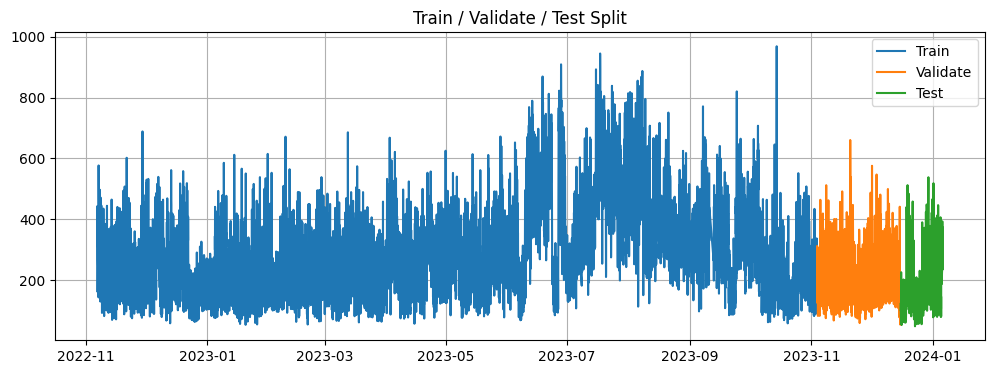

In [21]:
# === STEP 4: SPLIT - VALIDATE - TEST ===

n = len(series)
train_end = int(n * 0.85)
val_end   = int(n * 0.95)

train = series.iloc[:train_end]
validate = series.iloc[train_end:val_end]
test = series.iloc[val_end:]

exog_train = exog.iloc[:train_end]
exog_validate = exog.iloc[train_end:val_end]
exog_test = exog.iloc[val_end:]

print("Train:", len(train))
print("Validate:", len(validate))
print("Test:", len(test))

plt.figure(figsize=(12,4))
plt.plot(train, label='Train')
plt.plot(validate, label='Validate')
plt.plot(test, label='Test')
plt.legend()
plt.grid(True)
plt.title("Train / Validate / Test Split")
plt.show()


3.6.3 ADF Test (determine d)

In [22]:
# === STEP 5: ADF TEST ===
from statsmodels.tsa.stattools import adfuller

adf_stat, adf_p, *_ = adfuller(series.dropna())
print("ADF Statistic:", adf_stat)
print("ADF p-value:", adf_p)

if adf_p < 0.05:
    d = 0
else:
    d = 1

print("==> d =", d)


ADF Statistic: -6.180416177176416
ADF p-value: 6.47564307153125e-08
==> d = 0


3.6.4 ACF/PACF (verify p, q)

<Figure size 1000x300 with 0 Axes>

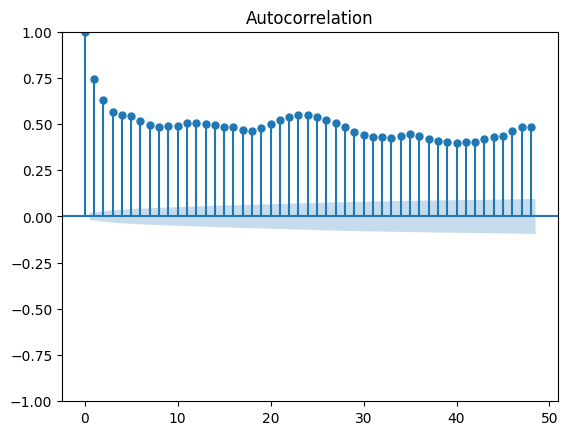

<Figure size 1000x300 with 0 Axes>

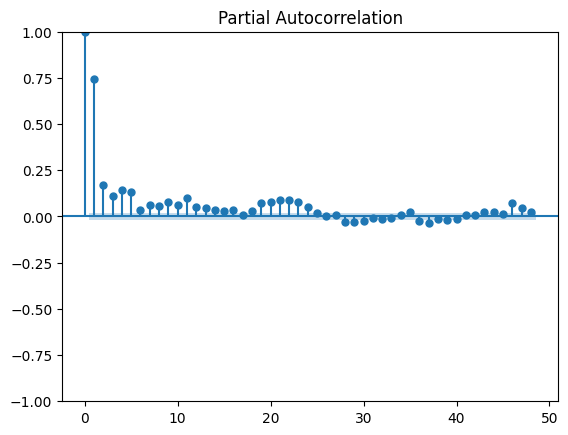

In [23]:
# === STEP 6: ACF / PACF ===
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10,3))
plot_acf(series, lags=48)
plt.show()

plt.figure(figsize=(10,3))
plot_pacf(series, lags=48, method='ywm')
plt.show()



In [24]:
print(df_hour.info())
print("\nNaN counts:\n", df_hour.isna().sum())
print("\nAny duplicate timestamps?", df_hour['date'].duplicated().any())

<class 'pandas.core.frame.DataFrame'>
Index: 10112 entries, 24 to 10233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          10112 non-null  datetime64[ns]
 1   active_power  10112 non-null  float64       
 2   temp          10112 non-null  float64       
 3   feels_like    10112 non-null  float64       
 4   pressure      10112 non-null  float64       
 5   humidity      10112 non-null  float64       
 6   speed         10112 non-null  float64       
 7   weekday       10112 non-null  int32         
 8   is_weekend    10112 non-null  int64         
 9   ap_lag_1h     10112 non-null  float64       
 10  ap_lag_24h    10112 non-null  float64       
 11  ap_roll_24h   10112 non-null  float64       
dtypes: datetime64[ns](1), float64(9), int32(1), int64(1)
memory usage: 987.5 KB
None

NaN counts:
 date            0
active_power    0
temp            0
feels_like      0
pressure        0
humid

3.6.5 Grid-search ARIMAX

In [26]:
# === STEP 7: GRID-SEARCH ARIMAX ===

import math
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

results = []

p_range = range(0,4)  # p = 0..3
q_range = range(0,4)  # q = 0..3

print("Grid-search ARIMAX")

for p in p_range:
    for q in q_range:
        try:
            model = SARIMAX(
                train,
                exog=exog_train,
                order=(p, d, q),                 # ONLY p,d,q
                enforce_stationarity=False,
                enforce_invertibility=False,
                simple_differencing=True
            )
            res = model.fit(method='lbfgs', maxiter=60, disp=False)

            val_pred = res.get_forecast(
                steps=len(validate), exog=exog_validate
            ).predicted_mean

            mae = mean_absolute_error(validate, val_pred)
            rmse = math.sqrt(mean_squared_error(validate, val_pred))

            results.append([p, q, res.aic, mae, rmse])
            print(f"ARIMAX({p},{d},{q}) → AIC={res.aic:.2f}, MAE={mae:.2f}, RMSE={rmse:.2f}")

        except Exception as e:
            print(f"Skip ARIMAX({p},{q}), error:", e)


Grid-search ARIMAX
ARIMAX(0,0,0) → AIC=101322.36, MAE=57.08, RMSE=75.06
ARIMAX(0,0,1) → AIC=101283.47, MAE=58.11, RMSE=75.51
ARIMAX(0,0,2) → AIC=100920.86, MAE=94.86, RMSE=119.27
ARIMAX(0,0,3) → AIC=100502.73, MAE=103.56, RMSE=130.66
ARIMAX(1,0,0) → AIC=101006.12, MAE=70.27, RMSE=88.41
ARIMAX(1,0,1) → AIC=100524.70, MAE=104.75, RMSE=132.45
ARIMAX(1,0,2) → AIC=100514.80, MAE=104.57, RMSE=132.12
ARIMAX(1,0,3) → AIC=100497.87, MAE=104.25, RMSE=131.89
ARIMAX(2,0,0) → AIC=100826.81, MAE=81.05, RMSE=101.84
ARIMAX(2,0,1) → AIC=100573.22, MAE=103.76, RMSE=132.22
ARIMAX(2,0,2) → AIC=101305.85, MAE=57.11, RMSE=75.08
ARIMAX(2,0,3) → AIC=100505.54, MAE=103.64, RMSE=130.95
ARIMAX(3,0,0) → AIC=100684.79, MAE=88.82, RMSE=112.06
ARIMAX(3,0,1) → AIC=100506.77, MAE=104.56, RMSE=132.11
ARIMAX(3,0,2) → AIC=101051.44, MAE=71.83, RMSE=89.55
ARIMAX(3,0,3) → AIC=100493.59, MAE=104.03, RMSE=131.53


3.6.6 SELECT BEST ARIMAX MODEL

In [28]:
# === STEP 8: SELECT BEST ARIMAX MODEL ===

import pandas as pd

# Convert results list → DataFrame
df_results = pd.DataFrame(results, columns=['p','q','AIC','MAE','RMSE'])

# Sort by RMSE then AIC
df_results_sorted = df_results.sort_values(['RMSE','AIC'], ascending=[True, True]).reset_index(drop=True)

print("=== TOP 5 ARIMAX MODELS (sorted by RMSE → AIC) ===")
print(df_results_sorted.head(5))

# Extract best row
best_row = df_results_sorted.iloc[0]

p_best = int(best_row['p'])
d_best = 0  
q_best = int(best_row['q'])

print("\n=== BEST ARIMAX MODEL SELECTED ===")
print(f"Best model: ARIMAX({p_best}, {d_best}, {q_best})")
print(f"AIC : {best_row['AIC']:.2f}")
print(f"MAE : {best_row['MAE']:.2f}")
print(f"RMSE: {best_row['RMSE']:.2f}")


=== TOP 5 ARIMAX MODELS (sorted by RMSE → AIC) ===
   p  q            AIC        MAE       RMSE
0  0  0  101322.358603  57.084788  75.063981
1  2  2  101305.854727  57.113649  75.078031
2  0  1  101283.474306  58.106235  75.507468
3  1  0  101006.118644  70.270957  88.409691
4  3  2  101051.441719  71.828101  89.554345

=== BEST ARIMAX MODEL SELECTED ===
Best model: ARIMAX(0, 0, 0)
AIC : 101322.36
MAE : 57.08
RMSE: 75.06


3.6.7 Refit Best ARIMAX & Show Model Summary

In [29]:
# === STEP 9: REFIT BEST ARIMAX MODEL ON TRAIN + VALIDATE ===

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Combine train + validate
train_val = series.iloc[:val_end]
exog_train_val = exog.iloc[:val_end]

# ==== REFIT ARIMAX (NO SEASONALITY) ====
best_model = SARIMAX(
    train_val,
    exog = exog_train_val,
    order = (p_best, d_best, q_best),   # ARIMAX uses only p,d,q
    enforce_stationarity = False,
    enforce_invertibility = False
).fit(disp=False)

print("=== ARIMAX MODEL SUMMARY (Train+Validate) ===")
print(best_model.summary())


=== ARIMAX MODEL SUMMARY (Train+Validate) ===
                               SARIMAX Results                                
Dep. Variable:           active_power   No. Observations:                 9606
Model:                        SARIMAX   Log Likelihood              -56473.045
Date:                Thu, 27 Nov 2025   AIC                         112962.090
Time:                        00:20:23   BIC                         113019.451
Sample:                             0   HQIC                        112981.545
                               - 9606                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temp            1.3273      0.215      6.161      0.000       0.905       1.750
humidity        0.0837      0.062      1.344      0.179      -0.038       0.206
pr

3.6.8 Forecast on TEST + calculate MAE, RMSE, MAPE + visualization 


=== ARIMAX TEST PERFORMANCE ===
Best model: ARIMAX(0,0,0)
MAE  = 56.78
RMSE = 75.03
MAPE = 33.52%


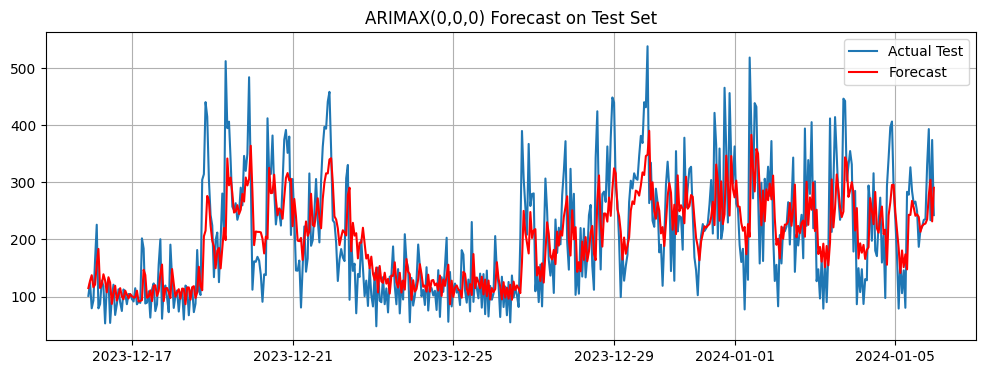

In [30]:
# === STEP 10: FORECAST TEST & EVALUATION ===

test_pred = best_model.get_forecast(
    steps=len(test),
    exog=exog_test
).predicted_mean

# align index
test_pred.index = test.index

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_test  = mean_absolute_error(test, test_pred)
rmse_test = np.sqrt(mean_squared_error(test, test_pred))
mape_test = np.mean(np.abs((test - test_pred) / test)) * 100

print("\n=== ARIMAX TEST PERFORMANCE ===")
print(f"Best model: ARIMAX({p_best},{d_best},{q_best})")
print(f"MAE  = {mae_test:.2f}")
print(f"RMSE = {rmse_test:.2f}")
print(f"MAPE = {mape_test:.2f}%")

# plot
plt.figure(figsize=(12,4))
plt.plot(test, label='Actual Test')
plt.plot(test_pred, color='red', label='Forecast')
plt.legend()
plt.grid(True)
plt.title(f"ARIMAX({p_best},{d_best},{q_best}) Forecast on Test Set")
plt.show()
